In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
train_df = pd.read_csv('../data/raw/train.csv')

In [5]:
train_df.head(10)

,business_id,labels
0,1000,1 2 3 4 5 6 7
1,1001,0 1 6 8
2,100,1 2 4 5 6 7
3,1006,1 2 4 5 6
4,1010,0 6 8
5,101,1 2 3 4 5 6
6,1011,2 3 5 6
7,1012,1 2 3 5 6
8,1014,1 2 4 5 6
9,1015,1 5 6 7


In [49]:
len(train_df)

2000

In [52]:
np.max(sorted(train_df.business_id))

4000

In [55]:
len(set(train_df.business_id))

2000

It seems there are only 2000 different buisiness types.

In [6]:
train_photo_to_biz = pd.read_csv('../data/raw/train_photo_to_biz_ids.csv')

In [50]:
len(train_photo_to_biz)

234842

In [7]:
train_photo_to_biz.head(10)

,photo_id,business_id
0,204149,3034
1,52779,2805
2,278973,485
3,195284,485
4,19992,485
5,80748,485
6,444996,1783
7,200285,35
8,90572,35
9,27565,1313


In [53]:
len(set(train_photo_to_biz.photo_id))

234842

In [54]:
len(set(train_photo_to_biz.business_id))

2000

In [68]:
train_photo_to_biz.groupby('business_id').count().describe()

,photo_id
count,2000.000000
mean,117.421000
std,205.032768
min,2.000000
25%,34.000000
50%,61.000000
75%,117.000000
max,2974.000000


In [62]:
n_photos_per_biz_id = list(train_photo_to_biz.groupby('business_id').count().photo_id)

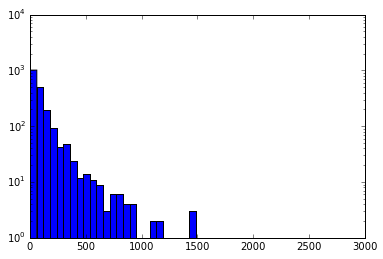

In [76]:
_ = plt.hist(sorted(n_photos_per_biz_id), log=True, bins=50)

Just looking if we could predict directly the business ID.
Data are not balanced correctly, and there are not many images per classes.

In [8]:
test_photo_to_biz = pd.read_csv('../data/raw/test_photo_to_biz.csv')

In [9]:
test_photo_to_biz.head(10)

,photo_id,business_id
0,317818,003sg
1,30679,003sg
2,455084,003sg
3,371381,003sg
4,86224,003sg
5,36076,003sg
6,46999,003sg
7,74896,003sg
8,169399,003sg
9,110581,003sg


In [69]:
len(set(test_photo_to_biz.photo_id))

237152

In [70]:
len(set(test_photo_to_biz.business_id))

10000

There are more test business id than training, so we really need to predict the label and then match them to their business id.

In [73]:
test_n_photos_per_biz_id = list(test_photo_to_biz.groupby('business_id').count().photo_id)

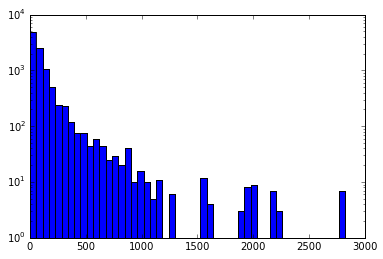

In [75]:
_ = plt.hist(sorted(test_n_photos_per_biz_id), log=True, bins=50)

It seems that we can do the prediction in the following way:
* predict probabilities of each label for every image (multi-label, attibutes are not mutually exclusive)
* merge probabilities for a given business_id.

In [11]:
attribute_id_to_label = {
    0: 'good_for_lunch',
    1: 'good_for_dinner',
    2: 'takes_reservations',
    3: 'outdoor_seating',
    4: 'restaurant_is_expensive',
    5: 'has_alcohol',
    6: 'has_table_service',
    7: 'ambience_is_classy',
    8: 'good_for_kids'}

In [15]:
import json

In [16]:
with open('../data/attribute_id_to_label.json', 'w') as jfile:
    json.dump(attribute_id_to_label, jfile, indent=2)

Prepare training data

For each image, we want a vector 9x1x1 with 1 if the image has the attribute, 0 otherwise

In [78]:
train_photo_id_to_biz_id = dict(zip(train_photo_to_biz.photo_id, train_photo_to_biz.business_id))

In [79]:
train_df_cleaned = train_df.dropna()

In [80]:
len(train_df_cleaned)

1996

In [81]:
len(train_df)

2000

In [82]:
biz_id_to_labels_str = dict(zip(train_df_cleaned.business_id, train_df_cleaned['labels']))

In [83]:
biz_id_to_labels = dict()
for biz_id, labels_str in biz_id_to_labels_str.items():
    biz_id_to_labels[biz_id] = [int(l) for l in labels_str.split()]

In [84]:
def OHE(labels, size=9):
    ohe = np.zeros((9, 1, 1))
    for l in labels:
        ohe[l][0][0] = 1
    return ohe

In [85]:
biz_id_to_ohe_labels = dict()
for biz_id, labels in biz_id_to_labels.items():
    biz_id_to_ohe_labels[biz_id] = OHE(labels)

In [94]:
train_photo_id_to_ohe_labels = dict()
for photo_id, biz_id in train_photo_id_to_biz_id.items():
    if biz_id in biz_id_to_ohe_labels:
        train_photo_id_to_ohe_labels[photo_id] = biz_id_to_ohe_labels[biz_id]

In [95]:
len(train_photo_id_to_ohe_labels)

234545

# Create train LMDB